MongoDB Challenges

Setup


In [3]:
import pickle
import pymongo
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from pymongo import MongoClient
client = MongoClient()
from collections import Counter

In [4]:
with open("heavy_metal_parsed.pkl", 'rb') as datafile:
    reviews = pickle.load(datafile)

In [5]:
first_review = reviews[0]
for line in first_review['raw']:
    print(line)

200 MOTELS (1971)
DIRECTORS: Tony Palmer, Frank Zappa
CAST: Frank Zappa, Ringo Starr, Mark Volman, Howard Kaylan, Keith
Moon
METAL CRED
Frank Zappa
Nun Desecration
THE MEAT
Beyond his metal sainthood for
battling the censor-witches of the PMRC and getting named checked by Deep
Purple in “Smoke on the Water”, musical visionary Frank Zappa led many rock
fans to heavy metal.
And, from there, he led many metal
fans to the outer expanses of rock’s possibilities.
Zappa also opened countless banging
heads to the far reaches of jazz, classical, doo-wop, and any other art form
that could involve (brilliant) noise and (brilliantly dumb) dirty jokes.
200
Motels is Zappa’s first crack at major motion picture madness, and it
embodies the much forgotten cultural moment when acid rock tumbled forever into
the black pits of rising heavy metal.
Surrealistic sketches and
psychedelic set pieces about the insanity of a being on tour are interspersed
among performances in which the Mothers jam with London 

In [6]:
print (first_review.keys())

dict_keys(['raw', 'head', 'year', 'sections', 'cast', 'direct', 'solid_metal_nuggets', 'title', 'metal_cred', 'the_meat'])


In [7]:
client = pymongo.MongoClient()
db = client.challenge_db
hmm = client.challenge_db.hmm_collection

hmm.drop() # Clear out any data we had in the collection.

hmm.insert_many(reviews);

In [8]:
hmm.count(())
hmm.find_one().keys()

dict_keys(['raw', 'head', '_id', 'sections', 'metal_cred', 'year', 'direct', 'solid_metal_nuggets', 'cast', 'title', 'the_meat'])

Challenge 1

Make a histogram of the years in the data. How many metal movies came out over the years?

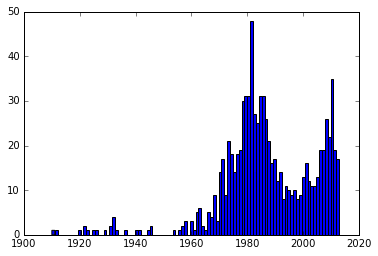

In [9]:
years = []
for film in hmm.find({}, {'year': 1, "_id": 0}):
    years.append(film['year'])
    
plt.hist(years, bins =100);

Challenge 2

Find the cast member that appeared in most Heavy Metal movies. Is there one that is shared by more than one of these movies? Or are they all completely different actors for every movie?

In [10]:
cursor = hmm.aggregate([
        {"$unwind": "$cast"},
        {"$group": {
            "_id": "$cast",
            "number": {"$sum" : 1}
            }},
        {"$sort": {"number": -1}},
        {"$limit": 5}
    ])

In [11]:
for i in cursor:
    print(i)

{'number': 22, '_id': ''}
{'number': 15, '_id': 'Alice Cooper'}
{'number': 14, '_id': 'Christopher Lee'}
{'number': 10, '_id': 'Arnold Schwarzenegger'}
{'number': 9, '_id': 'Ozzy Osbourne'}


Challenge 3

Find the most used words in Heavy Metal film titles. Is there a word that appears in a lot of them? Is it "The"? If it is something like "the", How can you get around that? Find one "meaningful" word that appears the most (this means non-structural word, unlike "the" or "a" or "in")

In [12]:
titles = []
for film in hmm.find({}, {"title": 1, "_id":0}):
    titles.append(film['title'])

In [13]:
def clean_str(s):
    return s.lower().replace(":", "")

In [14]:
title_words = []
for title in titles:
    words = [clean_str(word) for word in title.split()]
    title_words.extend(words)

In [15]:
counter = Counter(title_words)
counter.most_common(10)

[('the', 325),
 ('of', 147),
 ('metal', 35),
 ('a', 33),
 ('and', 27),
 ('in', 25),
 ('dead', 24),
 ('heavy', 19),
 ('rock', 19),
 ('2', 17)]

In [16]:
from stop_words import get_stop_words
stop_words = get_stop_words('en')


In [19]:
stop_words.append('the')

In [20]:
for i in title_words:
    if i in stop_words:
        title_words.remove(i)

In [21]:
counter = Counter(title_words)
counter.most_common(10)

[('metal', 35),
 ('dead', 24),
 ('heavy', 19),
 ('rock', 19),
 ('2', 17),
 ('black', 14),
 ('blood', 14),
 ('last', 13),
 ('ii', 12),
 ('devil', 12)]

Challenge 4

METAL CRED section lists themes included in these movies that makes them more metal. What were the top 5 metal cred keywords in the 70s? In 80s? In 90s, In 2000s?

In [23]:
def top_metal_cred_words(begin, end):
    mc_word_list = []

    query = {"year": {"$gte": begin, "$lte": end}}
    projection = {"metal_cred": 1, "year": 1, "_id": 0}

    for film in hmm.find(query, projection):
        for phrase in film["metal_cred"]:
            mc_word_list.extend([clean_str(word) for word in phrase.split()])
    
    # Filter out the stopwords.
    mc_word_list = [word for word in mc_word_list if word not in stop_words]
    return Counter(mc_word_list).most_common(5)

for year in range(1970, 2010, 10):
    print ("Top metal cred keywords from the %is:" % year)
    print (top_metal_cred_words(year, year + 9))
    print()

Top metal cred keywords from the 1970s:
[('metal', 167), ('cred', 157), ('satan', 21), ('’70s', 19), ('black', 14)]

Top metal cred keywords from the 1980s:
[('metal', 304), ('cred', 285), ('’80s', 82), ('–', 47), ('post-apocalypse', 31)]

Top metal cred keywords from the 1990s:
[('metal', 119), ('cred', 106), ('soundtrack', 41), ('black', 9), ('alice', 8)]

Top metal cred keywords from the 2000s:
[('metal', 188), ('cred', 162), ('soundtrack', 51), ('black', 14), ('porn', 12)]



Challenge 5

Let's use the length of the METAL CRED section as a proxy score for how metal a movie is. Let's call this the METAL SCORE. To each mongo document, add the metal_score as a new field.

In [24]:
for doc in hmm.find({}, {"metal_cred": 1}):
    metal_score = len(doc["metal_cred"])
    hmm.update_one({"_id": doc["_id"]}, {"$set": {"metal_score": metal_score}})

In [25]:
for doc in hmm.find({}, {"metal_cred": 1, "metal_score": 1, "_id": 0}).limit(4):
    print (doc)

{'metal_score': 3, 'metal_cred': ['METAL CRED', 'Frank Zappa', 'Nun Desecration']}
{'metal_score': 8, 'metal_cred': ['METAL CRED', 'Sword and Sorcery', 'Battle Elephants vs. Battle Rhinos', 'Pit of Death', 'Sparta band—UK', 'Spartan Warrior—UK', 'Leonidas band—Argentina', 'Xerxes band—Switzerland']}
{'metal_score': 5, 'metal_cred': ['METAL CRED', 'Post-Apocalypse', 'Big Brother', '1984 album—Van Halen', '“Big Brother” songs—A.N.D.,\nAntischism, Blackhole, Samson, Sed Lex, Soundscape, Thrashsteel, Wintercold']}
{'metal_score': 3, 'metal_cred': ['METAL CRED', 'Post-Apocalypse', '’80s\nItalian Exploitation']}


Challenge 6

Find the director that is MOST METAL per movie (director with the highest average metal score). Remember that some movies have multiple directors.

In [27]:
cursor = hmm.aggregate([
    {"$unwind": "$direct"},
    {"$group" : {
        "_id" : "$direct", 
        "film_count": {"$sum": 1},
        "avg_metal_score": {"$avg": "$metal_score"} 
    }},
    {"$sort": {"avg_metal_score": -1}},
    {"$limit": 5}
])

for most_metal_director in cursor:
    print (most_metal_director)


{'avg_metal_score': 75.0, '_id': 'John Milius', 'film_count': 1}
{'avg_metal_score': 27.0, '_id': 'David Jacobson', 'film_count': 1}
{'avg_metal_score': 18.0, '_id': 'Robert Hendrickson', 'film_count': 1}
{'avg_metal_score': 18.0, '_id': 'Laurence Merrick', 'film_count': 1}
{'avg_metal_score': 13.0, '_id': 'Bob Guccione', 'film_count': 1}


Challenge 7

The majority of directors and actors will have worked on a single movie. See if there are any directors that worked with an actor more than once. If so, find the director-actor duo that have worked together the most times.

In [28]:
cursor = hmm.aggregate([
    {"$unwind": "$direct"},
    {"$unwind": "$cast"},
    {"$group": {
        "_id" : {"director" : "$direct", "actor": "$cast"},
        "duo_count": {"$sum": 1 },
    }},
    {"$sort": {"duo_count": -1}},
    {"$limit": 5}
])

for director_actor_pair in cursor:
    print (director_actor_pair)


{'_id': {'actor': 'Sheri Moon Zombie', 'director': 'Rob Zombie'}, 'duo_count': 4}
{'_id': {'actor': 'Daria Nicolodi', 'director': 'Dario Argento'}, 'duo_count': 4}
{'_id': {'actor': 'George Eastman', 'director': 'Joe D’Amato'}, 'duo_count': 4}
{'_id': {'actor': 'Christopher Lee', 'director': 'Peter Jackson'}, 'duo_count': 4}
{'_id': {'actor': 'Jessie Misskelley', 'director': 'Bruce Sinofsky'}, 'duo_count': 3}


Challenge 8

Create an index on the 'director' field to make the queries involving it faster. What is an index?



In [29]:
hmm.create_index("direct")


'direct_1'

Challenge 9 (Optional challenge for early finishers)

For each decade, make a histogram of metal scores. Also, calculate the average metal score for each decade. Which decade was the most pure metal decade?

Note (rather than a challenge)

In the latest version of mongo, you can do a text query. To do this, you need to create one (only one) text-based index. Let's index the_meat field so we can make text search queries on it (in pymongo):

db.reviews.create_index([("the_meat", pymongo.TEXT,)])

Now you can do text search. For example, let's search for the phrase "hitting power chords" within "the_meat" fields of all our documents.

db.reviews.find({"$text": {"$search": "hitting power
chords"}}).count()

206
It has found 206 reviews. I can print the titles of the first 10 reviews that were returned in this text search:

ten_matches = r.find({"$text": {"$search": "hitting power chords"}}).limit(10)
for match in ten_matches:
    print match["title"]


DOMINATOR
REPO: THE GENETIC OPERA
GREMLINS 2: THE NEW BATCH
VICE SQUAD
THE JERKY BOYS: THE MOVIE
THE SONG REMAINS THE SAME
THE EXORCIST
THE CROW
CANNIBAL HOLOCAUST
HOSTEL
Enjoy your text searches : ) These can be very useful in some apps.

Twitter API Extension

Create a mongo collection of tweets about something (anything you choose).

Each mongo document should contain the text, username, favorite count and retweet count of the tweet.